In [1]:
#Load the data for a station and organize for precipitation model
import pandas as pd
import numpy as np
import math
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:

def date_to_integer(date_string, date_format='%Y-%m-%d'):
    """
    Converts a date string to an integer representation.

    Args:
        date_string (str): The date string to convert.
        date_format (str, optional): The format of the date string. Defaults to '%Y-%m-%d'.

    Returns:
        int: The integer representation of the date.
    """
    date_object = datetime.datetime.strptime(date_string, date_format).date()
    return int(date_object.strftime('%Y%m%d'))

# Example usage
# date_str = '2025-04-06'
# date_int = date_to_integer(date_str)
# print(date_int)

In [3]:
def fn_make_matrix_pr01(stid,ipd,nhours,ndays,nyears_row,nyears_col):

    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Read in all data files
    # 2. Find the common starting date that will be used to align the matrices
    # 3. Keep only the values that fit the common starting date
    # 4. Combine the data into one large matrix for the StationID 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    #Air temperature (one variable recorded once an hour a day)
    df_at = pd.read_csv(ipd + stid + "_model_data_airtemp.csv")
    v_date_at = datetime.strptime(df_at.iloc[0,2], "%Y-%m-%d").date()
    #Relative Hunidity (3 variables recorded once a day)
    df_rh = pd.read_csv(ipd + stid + "_model_data_relhum.csv")
    v_date_rh = datetime.strptime(df_rh.iloc[0,4], "%Y-%m-%d").date()
    #Precipitation (one variable recorded once an hour a day)
    df_pr = pd.read_csv(ipd + stid + "_model_data_precip.csv")
    v_date_pr = datetime.strptime(df_pr.iloc[0,2], "%Y-%m-%d").date()


    # 2. Find the offsets needed to all datasets start at same starting date
    v_date_minimum = min(v_date_at,v_date_rh,v_date_pr)
    v_date_minimum

    #Identify offsets to use so all datadata vectors are appropriately aligned 
    offset_at = -(v_date_minimum - v_date_at).days
    offset_rh = -(v_date_minimum - v_date_rh).days
    offset_pr = -(v_date_minimum - v_date_pr).days

    # 3. Get vectors of data for each measure
    #These vectors all start on the same date
    vc_at1 = df_at.iloc[offset_at:(len(df_at.iloc[:,1])-offset_at),1]
    vc_rh1 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,1])-offset_rh),1]
    vc_rh2 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,2])-offset_rh),2]
    vc_rh3 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,3])-offset_rh),3]
    vc_pr1 = df_pr.iloc[offset_pr:(len(df_pr.iloc[:,1])-offset_pr),1]


    # 4. Interleave vectors so we get a complete vector of all metrics
    #Start with the once a day vectors and loop over the number of days as defined by once a day vector
    #These set how many years of data are needed : nyears_row + nyears_col
    nyears_data_limit = nyears_row + nyears_col + 1
    nrows = nhours*ndays*nyears_row
    ncols = nhours*ndays*nyears_col 
    
    # set the number of metrics created each day
    # Metrics measured at hourly intervals are put into day metrics
    # And ordered from most recent hour to most distant hour from left to right
    # Day metrics are also ordered most recent day to most distant day left to right
    ndaily_metrics = 2*nhours + 3*1

    #Set the total number of days of data needed for the model
    num_days = nyears_data_limit*ndays
    #print(f"Number of days: {num_days}")

    is_first = 1

    #Construct the vector that holds all data values (valid and missing)
    for i_day in range(num_days):
        i_day_hour_end = (i_day + 1)*nhours - 1
        i_day_hour_start = i_day_hour_end - (nhours -1)
        va = vc_pr1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]
        vb = vc_rh1[(i_day + offset_rh):(i_day + offset_rh)]
        vc = vc_rh2[(i_day + offset_rh):(i_day + offset_rh)]
        vd = vc_rh3[(i_day + offset_rh):(i_day + offset_rh)]
        ve = vc_at1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]

        #vmt_full set = np.concatenate((vmt_one_day,va,vb,vc,vd,ve)) 
        #print(i_day)
        if is_first == 0:
            vmt_full_set = np.concatenate((vmt_full_set,va,vb,vc,vd,ve))
            #print(len(vmt_full_set))
        else:
            is_first = 0
            vmt_full_set = np.concatenate((va,vb,vc,vd,ve))
            #print(len(vmt_full_set))

    #print(f"Length of data vector: {len(vmt_full_set)}")


    #Organize the data vector into an array which will be returned to the function call
    #Create an empty matrix in which data are organized
    nrows = nyears_row*ndays
    ncols = nyears_col*ndays*ndaily_metrics
    nrow_days =  nyears_row*ndays
    ncol_days =  nyears_col*ndays
    data_limit = len(vmt_full_set)
    #print(f"Number of columns in matrix: {ncols}")
    #print(f"Limit of data: {data_limit}")

    #Make template matrix to house data
    template_matrix = np.zeros((nrows, ncols), dtype=np.float16)

    # Fill the matrix
    for i in range(nrow_days):
        vc_start = i*(ndaily_metrics)
        vc_end = ncols + vc_start
        
        if vc_end < data_limit:
            template_matrix[i] = vmt_full_set[(vc_start):(vc_end)]

    #   print(vc_start)
    #   print(vc_end)
    #   print(len(vmt_full_set[(vc_start):(vc_end)]))
        
    return template_matrix

In [4]:
def fn_make_matrix_pr04(stid_keys,nstations,ipd,nhours,ndays,nyears_row,nyears_col):

    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Read in all data files for multiple stations
    # 2. Find the common starting date that will be used to align the matrices
    # 3. Keep only the values that fit the common starting date
    # 4. Combine the data into one large matrix for the StationID 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    #Create two objects of length 12
    #data_list which contains the metrics for stations 1-4, the first is the target
    #data_start_date which contains the most recent date for each file
    vc_first_rcd = [0,3,6,9]
    num_stations = len(vc_first_rcd)
    vc_st_id = stid_keys.iloc[:,0]
    vc_path = stid_keys.iloc[:,3]
    vc_fnames = stid_keys.iloc[:,2]

    data_list = []
    data_start_date = []
    
    for i in range(0, num_stations):
            #Air temperature (one variable recorded once an hour a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]]
            df_at = pd.read_csv(infile)
            data_list.append(df_at)
            dt_first = datetime.strptime(df_at.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
            
            #Precipitation (one variable recorded once an hour a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]+1] 
            df_pr = pd.read_csv(infile)
            data_list.append(df_pr)
            dt_first = datetime.strptime(df_pr.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
            
            #Relative Humidity (3 variables recorded once a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]+2]
            df_rh = pd.read_csv(infile)
            data_list.append(df_rh)
            dt_first = datetime.strptime(df_rh.iloc[0,4], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
 
     # 2. Find the offsets needed to all datasets start at same starting date
    v_date_minimum = min(data_start_date)
    print(v_date_minimum)

    #Identify offsets to use so all datadata vectors are appropriately aligned 
    upper_range = len(data_start_date)
    
    date_offsets_list = []
    for i in range(0, upper_range):
        date_offset = data_start_date[i] - v_date_minimum
        #Temporarily set to 0, revise later
        #date_offset = 0
        date_offsets_list.append(date_offset)
    
    # 3. Get vectors of data for each measure
    #These vectors all start on the same date

    data_vectors_list = []
    for i in vc_first_rcd:
        tdt = data_list[i]
        tof = date_offsets_list[i]
        
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start
        vc_at1 = tdt.iloc[i_start:i_end,1]
        data_vectors_list.append(vc_at1)

        tdt = data_list[i+1]
        tof = date_offsets_list[i+1]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start
        vc_pr1 = tdt.iloc[i_start:i_end,1]
        data_vectors_list.append(vc_pr1)
            
        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh1 = tdt.iloc[i_start:i_end,1]
        data_vectors_list.append(vc_rh1)

        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh2 = tdt.iloc[i_start:i_end,2]
        data_vectors_list.append(vc_rh2)

        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh3 = tdt.iloc[i_start:i_end,3]
        data_vectors_list.append(vc_rh3)
    
    # 4. Interleave vectors so we get a complete vector of all metrics
    #Start with the once a day vectors and loop over the number of days as defined by once a day vector
    #These set how many years of data are needed : nyears_row + nyears_col
    nyears_data_limit = nyears_row + nyears_col + 1
    nrows = nhours*ndays*nyears_row
    ncols = nhours*ndays*nyears_col 
        
    # set the number of metrics created each day
    # Metrics measured at hourly intervals are put into day metrics
    # And ordered from most recent hour to most distant hour from left to right
    # Day metrics are also ordered most recent day to most distant day left to right
    ndaily_metrics = 2*nhours + 3*1

    #Set the total number of days of data needed for the model
    num_days = nyears_data_limit*ndays
    #print(f"Number of days: {num_days}")

    is_first = 1

    #Construct the vector that holds all data values (valid and missing)
    #Assumes that all vectors in data_vectors_list match on date start
    #data are organized by day, target station, other stations
    for i_day in range(num_days):
        i_day_hour_end = (i_day + 1)*nhours - 1
        i_day_hour_start = i_day_hour_end - (nhours -1)
        
        #Target Station
        va2 = data_vectors_list[0][(i_day_hour_start):(i_day_hour_end)]  #AT
        va1 = data_vectors_list[1][(i_day_hour_start):(i_day_hour_end)]  #PR
        va3 = data_vectors_list[2][i_day:i_day]                          #RH1
        va4 = data_vectors_list[3][i_day:i_day]                          #RH2
        va5 = data_vectors_list[4][i_day:i_day]                          #RH3
        #Station 1
        vb2 = data_vectors_list[5][(i_day_hour_start):(i_day_hour_end)]  #AT
        vb1 = data_vectors_list[6][(i_day_hour_start):(i_day_hour_end)]  #PR
        vb3 = data_vectors_list[7][i_day:i_day]                          #RH1
        vb4 = data_vectors_list[8][i_day:i_day]                          #RH2
        vb5 = data_vectors_list[9][i_day:i_day]                          #RH3
        #Station 2
        vc2 = data_vectors_list[10][(i_day_hour_start):(i_day_hour_end)]  #AT
        vc1 = data_vectors_list[11][(i_day_hour_start):(i_day_hour_end)]  #PR
        vc3 = data_vectors_list[12][i_day:i_day]                          #RH1
        vc4 = data_vectors_list[13][i_day:i_day]                          #RH2
        vc5 = data_vectors_list[14][i_day:i_day]                          #RH3
        #Station 3
        vd2 = data_vectors_list[15][(i_day_hour_start):(i_day_hour_end)]  #AT
        vd1 = data_vectors_list[16][(i_day_hour_start):(i_day_hour_end)]  #PR
        vd3 = data_vectors_list[17][i_day:i_day]                          #RH1
        vd4 = data_vectors_list[18][i_day:i_day]                          #RH2
        vd5 = data_vectors_list[19][i_day:i_day]                          #RH3
            

        #vmt_full set = np.concatenate((vmt_one_day,va,vb,vc,vd,ve)) 
        #print(i_day)
        if is_first == 0:
            vmt_full_set = np.concatenate((vmt_full_set,va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))
            #print(len(vmt_full_set))
        else:
            is_first = 0
            vmt_full_set = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))
            #print(len(vmt_full_set))

    print(f"Length of data vector: {len(vmt_full_set)}")


    #Organize the data vector into an array which will be returned to the function call
    #Create an empty matrix in which data are organized
    #nstations = 4
    nrows = nyears_row*ndays
    ncols = nstations*nyears_col*ndays*ndaily_metrics
    nrow_days =  nyears_row*ndays
    ncol_days =  nyears_col*ndays
    data_limit = len(vmt_full_set)
    #print(f"Number of columns in matrix: {ncols}")
    #print(f"Limit of data: {data_limit}")

    #Make template matrix to house data
    template_matrix = np.zeros((nrows, ncols), dtype=np.float16)

    # Fill the matrix
    for i in range(nrow_days):
        vc_start = i*(ndaily_metrics)
        vc_end = ncols + vc_start
            
        if vc_end < data_limit:
            template_matrix[i] = vmt_full_set[(vc_start):(vc_end)]

            
    return template_matrix

In [5]:
def fn_make_matrix_pr05(stid_keys,nstations,ipd,nhours,ndays,nyears_row,nyears_col,n_metrics):
    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Read in all data files for multiple stations
    # 2. Find the common starting date that will be used to align the matrices
    # 3. Keep only the values that fit the common starting date
    # 4. Combine the data into one large matrix for the StationID 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    #Create two objects of length 12
    #data_list which contains the metrics for stations 1-4, the first is the target
    #data_start_date which contains the most recent date for each file
    vc_first_rcd = [0,3,6,9]
    num_stations = len(vc_first_rcd)
    vc_st_id = stid_keys.iloc[:,0]
    vc_path = stid_keys.iloc[:,3]
    vc_fnames = stid_keys.iloc[:,2]

    data_list = []
    data_start_date = []
    
    for i in range(0, num_stations):
            #Air temperature (one variable recorded once an hour a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]]
            df_at = pd.read_csv(infile)
            data_list.append(df_at)
            dt_first = datetime.strptime(df_at.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
            
            #Precipitation (one variable recorded once an hour a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]+1] 
            df_pr = pd.read_csv(infile)
            data_list.append(df_pr)
            dt_first = datetime.strptime(df_pr.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
            
            #Relative Humidity (3 variables recorded once a day)
            infile = vc_path.iloc[vc_first_rcd[i]] + "\\" + vc_fnames.iloc[vc_first_rcd[i]+2]
            df_rh = pd.read_csv(infile)
            data_list.append(df_rh)
            dt_first = datetime.strptime(df_rh.iloc[0,4], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            #print(dt_first)
 
     # 2. Find the offsets needed to all datasets start at same starting date
    v_date_minimum = min(data_start_date)
    #print(v_date_minimum)

    #Identify offsets to use so all datadata vectors are appropriately aligned 
    upper_range = len(data_start_date)
    
    date_offsets_list = []
    for i in range(0, upper_range):
        date_offset = data_start_date[i] - v_date_minimum
        #Temporarily set to 0, revise later
        #date_offset = 0
        date_offsets_list.append(date_offset)
    
    # 3. Get vectors of data for each measure
    #These vectors all start on the same date

    data_vectors_list = []
    for i in vc_first_rcd:
        tdt = data_list[i]
        tof = date_offsets_list[i]
        
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start
        vc_at1 = tdt.iloc[i_start:i_end,1]
        data_vectors_list.append(vc_at1)

        tdt = data_list[i+1]
        tof = date_offsets_list[i+1]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start
        vc_pr1 = tdt.iloc[i_start:i_end,1]
        data_vectors_list.append(vc_pr1)
            
        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh1 = tdt.iloc[i_start:i_end,1]
        #adjust from 1 a day to 24 a day measures
        vc_rh1_24 = np.repeat(vc_rh1, nhours)
        data_vectors_list.append(vc_rh1_24)
    
        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh2 = tdt.iloc[i_start:i_end,2]
        #adjust from 1 a day to 24 a day measures
        vc_rh2_24 = np.repeat(vc_rh2, nhours)
        data_vectors_list.append(vc_rh2_24)

        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        i_start = tof.days
        i_end = len(tdt.iloc[:,1]) - i_start        
        vc_rh3 = tdt.iloc[i_start:i_end,3]
        #adjust from 1 a day to 24 a day measures
        vc_rh3_24 = np.repeat(vc_rh3, nhours)
        data_vectors_list.append(vc_rh3_24)

    for i in range(0,20):
        print(f"Length vector: {len(data_vectors_list[i])}")
        
    # 4. Interleave vectors so we get a complete vector of all metrics
    #Start with the once a day vectors and loop over the number of days as defined by once a day vector
    #These set how many years of data are needed : nyears_row + nyears_col
    nyears_data_limit = nyears_row + nyears_col + 1
    nrows = nhours*ndays*nyears_row
    ncols = nhours*ndays*nyears_col 
        
    # Set the number of metrics created each day
    # And ordered from most recent hour to most distant hour from left to right
    # Day metrics are also ordered most recent day to most distant day left to right
    ndaily_metrics = n_metrics*nhours

    #Set the total number of days of data needed for the model
    num_days = nyears_data_limit*ndays
    num_days_hrs = nhours*num_days
    #num_days_hrs = nhours*100

    print(f"Number of years total needed: {nyears_data_limit}")
    print(f"Number of days total needed: {num_days}")
    print(f"Number of days and hours: {num_days_hrs}")
    print(f"Number of matrix columns per metric: {ncols}")
    print(f"Number of matrix rows: {nrows}")
    #print(f"tgt : {data_vectors_list[1][0:23]}")
    is_first = 1

    #Construct the vector that holds all data values (valid and missing)
    #Assumes that all vectors in data_vectors_list match on date start
    #data are organized by day, target station, other stations
    for i_day in range(num_days_hrs):
        #print(i_day)
        i_day_hour_end_tgt = i_day + ncols
        i_day_hour_start_tgt = i_day
        
        i_day_hour_end_pred = i_day_hour_end_tgt + 1
        i_day_hour_start_pred = i_day_hour_start_tgt + 1
        
        #print(f"start :{i_day_hour_start_tgt}")
        #print(f"end :{i_day_hour_end_tgt}")
        
        #Target Station
        if nstations > 0:
            va2 = data_vectors_list[0][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #AT
            va1 = data_vectors_list[1][(i_day_hour_start_tgt):(i_day_hour_end_tgt)]  #PR
            va3 = data_vectors_list[2][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH1
            va4 = data_vectors_list[3][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH2
            va5 = data_vectors_list[4][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH3
        #Station 1
        if nstations > 1:
            vb2 = data_vectors_list[5][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #AT
            vb1 = data_vectors_list[6][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #PR
            vb3 = data_vectors_list[7][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH1
            vb4 = data_vectors_list[8][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH2
            vb5 = data_vectors_list[9][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH3        
        #Station 2
        if nstations > 2:
            vc2 = data_vectors_list[10][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #AT
            vc1 = data_vectors_list[11][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #PR
            vc3 = data_vectors_list[12][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH1
            vc4 = data_vectors_list[13][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH2
            vc5 = data_vectors_list[14][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH3        
        #Station 3
        if nstations > 3:
            vd2 = data_vectors_list[15][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #AT
            vd1 = data_vectors_list[16][(i_day_hour_start_pred):(i_day_hour_end_pred)]  #PR
            vd3 = data_vectors_list[17][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH1
            vd4 = data_vectors_list[18][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH2
            vd5 = data_vectors_list[19][(i_day_hour_start_pred):(i_day_hour_end_pred)]   #RH3        

        if is_first == 0:
            if nstations == 1:
                vc_row = np.concatenate((va1,va2,va3,va4,va5))
            if nstations == 2:
                vc_row = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5))
            if nstations == 3:
                vc_row = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5))
            if nstations == 4:
                vc_row = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))

            vmt_full_set = np.vstack((vmt_full_set, vc_row))
            print(vmt_full_set.shape)
        else:
            is_first = 0
            
            if nstations == 1:
                vmt_full_set = np.concatenate((va1,va2,va3,va4,va5))
            if nstations == 2:
                vmt_full_set = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5))
            if nstations == 3:
                vmt_full_set = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5))
            if nstations == 4:
                vmt_full_set = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))

    return vmt_full_set


In [6]:
# data = {
#     'st_id': [72508014740,72508014740,72508014740, 72504094702,72504094702,72504094702,72510094746,72510094746,72510094746,72505004781,72505004781,72505004781],
#     'target_station': [72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740],
#     'fnames': ['72508014740_model_data_airtemp.csv', '72508014740_model_data_precip.csv', '72508014740_model_data_relhum.csv',
#         '72504094702_model_data_airtemp.csv', '72504094702_model_data_precip.csv', '72504094702_model_data_relhum.csv',
#         '72510094746_model_data_airtemp.csv', '72510094746_model_data_precip.csv', '72510094746_model_data_relhum.csv',
#         '72505004781_model_data_airtemp.csv', '72505004781_model_data_precip.csv', '72505004781_model_data_relhum.csv'],
#     'path': ['D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\'],
#     'vect_close_bkt2': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
# }

# dt_analysis_set_keys = pd.DataFrame(data)
# dt_analysis_set_keys

In [7]:
def fn_make_matrix_pr02(stid_keys,nstations,ipd,nhours,ndays,nyears_row,nyears_col):

    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Read in all data files for multiple stations
    # 2. Find the common starting date that will be used to align the matrices
    # 3. Keep only the values that fit the common starting date
    # 4. Combine the data into one large matrix for the StationID 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    #Create two objects of length 12
    #data_list which contains the metrics for stations 1-4, the first is the target
    #data_start_date which contains the most recent date for each file
    vc_first_rcd = [0,3,6,9]
    num_stations = len(vc_first_rcd)
    vc_st_id = stid_keys.iloc[:,0]
    vc_path = stid_keys.iloc[:,3]
    vc_fnames = stid_keys.iloc[:,2]

    data_list = []
    data_start_date = []

    for i in range(0, num_stations):
            #Air temperature (one variable recorded once an hour a day)
            infile = vc_path[vc_first_rcd[i]] + "\\" + vc_fnames[vc_first_rcd[i]]
            df_at = pd.read_csv(infile)
            data_list.append(df_at)
            dt_first = datetime.strptime(df_at.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)

            #Precipitation (one variable recorded once an hour a day)
            infile = vc_path[vc_first_rcd[i]] + "\\" + vc_fnames[vc_first_rcd[i]+1] 
            df_pr = pd.read_csv(infile)
            data_list.append(df_pr)
            dt_first = datetime.strptime(df_pr.iloc[0,2], "%Y-%m-%d").date()
            data_start_date.append(dt_first)
            
            #Relative Humidity (3 variables recorded once a day)
            infile = vc_path[vc_first_rcd[i]] + "\\" + vc_fnames[vc_first_rcd[i]+2]
            df_rh = pd.read_csv(infile)
            data_list.append(df_rh)
            dt_first = datetime.strptime(df_rh.iloc[0,4], "%Y-%m-%d").date()
            data_start_date.append(dt_first)


    # 2. Find the offsets needed to all datasets start at same starting date
    v_date_minimum = min(data_start_date)

    #Identify offsets to use so all datadata vectors are appropriately aligned 
    upper_range = len(data_start_date)

    date_offsets_list = []
    for i in range(0, upper_range):
        date_offset = data_start_date[i] - v_date_minimum
        #Temporarily set to 0, revise later
        date_offset = 0
        date_offsets_list.append(date_offset)

    # 3. Get vectors of data for each measure
    #These vectors all start on the same date

    data_vectors_list = []
    for i in vc_first_rcd:
        tdt = data_list[i]
        tof = date_offsets_list[i]
        vc_at1 = tdt.iloc[date_offsets_list[i]:(len(tdt.iloc[:,1])-tof),1]
        data_vectors_list.append(vc_at1)
            
        tdt = data_list[i+1]
        tof = date_offsets_list[i+1]
        vc_pr1 = tdt.iloc[date_offsets_list[i+1]:(len(tdt.iloc[:,1])-tof),1]
        data_vectors_list.append(vc_pr1)
            
        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        vc_rh1 = tdt.iloc[date_offsets_list[i+2]:(len(tdt.iloc[:,1])-tof),1]
        data_vectors_list.append(vc_rh1)

        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        vc_rh2 = tdt.iloc[date_offsets_list[i+2]:(len(tdt.iloc[:,1])-tof),2]
        data_vectors_list.append(vc_rh2)

        tdt = data_list[i+2]
        tof = date_offsets_list[i+2]
        vc_rh3 = tdt.iloc[date_offsets_list[i+2]:(len(tdt.iloc[:,1])-tof),3]
        data_vectors_list.append(vc_rh3)

    

    # 4. Interleave vectors so we get a complete vector of all metrics
    #Start with the once a day vectors and loop over the number of days as defined by once a day vector
    #These set how many years of data are needed : nyears_row + nyears_col
    nyears_data_limit = nyears_row + nyears_col + 1
    nrows = nhours*ndays*nyears_row
    ncols = nhours*ndays*nyears_col 
        
    # set the number of metrics created each day
    # Metrics measured at hourly intervals are put into day metrics
    # And ordered from most recent hour to most distant hour from left to right
    # Day metrics are also ordered most recent day to most distant day left to right
    ndaily_metrics = 2*nhours + 3*1

    #Set the total number of days of data needed for the model
    num_days = nyears_data_limit*ndays
    #print(f"Number of days: {num_days}")

    is_first = 1

    #Construct the vector that holds all data values (valid and missing)
    #Assumes that all vectors in data_vectors_list match on date start
    #data are organized by day, target station, other stations
    for i_day in range(num_days):
        i_day_hour_end = (i_day + 1)*nhours - 1
        i_day_hour_start = i_day_hour_end - (nhours -1)
            
        va2 = data_vectors_list[0][(i_day_hour_start):(i_day_hour_end)]  #AT
        va1 = data_vectors_list[1][(i_day_hour_start):(i_day_hour_end)]  #PR
        va3 = data_vectors_list[2][i_day:i_day]                          #RH1
        va4 = data_vectors_list[3][i_day:i_day]                          #RH2
        va5 = data_vectors_list[4][i_day:i_day]                          #RH3

        vb2 = data_vectors_list[5][(i_day_hour_start):(i_day_hour_end)]  #AT
        vb1 = data_vectors_list[6][(i_day_hour_start):(i_day_hour_end)]  #PR
        vb3 = data_vectors_list[7][i_day:i_day]                          #RH1
        vb4 = data_vectors_list[8][i_day:i_day]                          #RH2
        vb5 = data_vectors_list[9][i_day:i_day]                          #RH3

        vc2 = data_vectors_list[10][(i_day_hour_start):(i_day_hour_end)]  #AT
        vc1 = data_vectors_list[11][(i_day_hour_start):(i_day_hour_end)]  #PR
        vc3 = data_vectors_list[12][i_day:i_day]                          #RH1
        vc4 = data_vectors_list[13][i_day:i_day]                          #RH2
        vc5 = data_vectors_list[14][i_day:i_day]                          #RH3

        vd2 = data_vectors_list[15][(i_day_hour_start):(i_day_hour_end)]  #AT
        vd1 = data_vectors_list[16][(i_day_hour_start):(i_day_hour_end)]  #PR
        vd3 = data_vectors_list[17][i_day:i_day]                          #RH1
        vd4 = data_vectors_list[18][i_day:i_day]                          #RH2
        vd5 = data_vectors_list[19][i_day:i_day]                          #RH3
            

        #vmt_full set = np.concatenate((vmt_one_day,va,vb,vc,vd,ve)) 
        #print(i_day)
        if is_first == 0:
            vmt_full_set = np.concatenate((vmt_full_set,va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))
            #print(len(vmt_full_set))
        else:
            is_first = 0
            vmt_full_set = np.concatenate((va1,va2,va3,va4,va5,vb1,vb2,vb3,vb4,vb5,vc1,vc2,vc3,vc4,vc5,vd1,vd2,vd3,vd4,vd5))
            #print(len(vmt_full_set))

    print(f"Length of data vector: {len(vmt_full_set)}")


    #Organize the data vector into an array which will be returned to the function call
    #Create an empty matrix in which data are organized
    nstations = 4
    nrows = nyears_row*ndays
    ncols = nstations*nyears_col*ndays*ndaily_metrics
    nrow_days =  nyears_row*ndays
    ncol_days =  nyears_col*ndays
    data_limit = len(vmt_full_set)
    #print(f"Number of columns in matrix: {ncols}")
    #print(f"Limit of data: {data_limit}")

    #Make template matrix to house data
    template_matrix = np.zeros((nrows, ncols), dtype=np.float16)

    # Fill the matrix
    for i in range(nrow_days):
        vc_start = i*(ndaily_metrics)
        vc_end = ncols + vc_start
            
        if vc_end < data_limit:
            template_matrix[i] = vmt_full_set[(vc_start):(vc_end)]

        #   print(vc_start)
        #   print(vc_end)
        #   print(len(vmt_full_set[(vc_start):(vc_end)]))
            
    return template_matrix

In [8]:
#STEP 1.  Select a station using ID to get its related stations
# Get file of target stations and their related stations
# ipd01 = "\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\2024\\"
ipd02 = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"
# ipd02 = "\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\"
dt_trg_set = ipd02 + "Target_station_analysis_set.csv"
lst_target_stations = [
  "74486094789",
  "72518014735",
  "72508014740",
  "72526014860",
  "72406093721",
  "72401013740",
  "72219013874",
  "72423093821",
  "72428014821",
  "72327013897"
]

#Select the target station for which predictions will be made
#72508014740 is JFK airport
st_id = lst_target_stations[2]
num_st_keep = 4   #num of stations to keep for analysis
analysis_set = dt_trg_set
dt_analysis_set = pd.read_csv(analysis_set)
dt_analysis_set['path'] = ipd02
dt01 = dt_analysis_set[dt_analysis_set['target_station']==int(st_id)]
#uniq_stat = dt01['vect_close_bkt2'].unique()[:2]
uniq_station = dt01['st_id'].unique()[:num_st_keep]
dt02 = dt01[dt01['st_id'].isin(uniq_station)]

selected_columns = ['st_id','target_station',
                    'fnames','path','vect_close_bkt2']
#The output below is fed to STEP 2 to run the analysis
dt_analysis_set_keys = dt02[selected_columns].copy()

dt_analysis_set_keys

,st_id,target_station,fnames,path,vect_close_bkt2
120,72508014740,72508014740,72508014740_model_data_airtemp.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,1
121,72508014740,72508014740,72508014740_model_data_precip.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,1
122,72508014740,72508014740,72508014740_model_data_relhum.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,1
123,72504094702,72508014740,72504094702_model_data_airtemp.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
124,72504094702,72508014740,72504094702_model_data_precip.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
125,72504094702,72508014740,72504094702_model_data_relhum.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
126,72510094746,72508014740,72510094746_model_data_airtemp.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
127,72510094746,72508014740,72510094746_model_data_precip.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
128,72510094746,72508014740,72510094746_model_data_relhum.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,3
129,72505004781,72508014740,72505004781_model_data_airtemp.csv,D:\CodeLibrary\Python\weathermetrics\data\weat...,4


In [9]:
# #Temp to test fn05
# #Parameters governing data matrix
# stid_keys = dt_analysis_set_keys
# nstations = 1
# ipd = ipd02
# nhours = 24
# ndays = 365
# nyears_row = 1
# nyears_col = 1
# n_metrics = 5

# rtn_matrix = fn_make_matrix_pr05(stid_keys,nstations,ipd,nhours,ndays,nyears_row,nyears_col,n_metrics)
# print(rtn_matrix.shape)

In [10]:
#STEP 2.  Use elements created in STEP 1 to get a data matrix for analysis
#All the available stations which have all three metrics needed for model
#vc_stid = dt_analysis_set_keys[['st_id']].drop_duplicates()

#Organize the data based on the nature of the data so they all conform to the same size matrices
#The metrics included are
#  AT - air temperature in Celcius
#  RH - relative humidity in Percent
#  PR - precipitation in MM

#Put them all in appropriate matrices and create list of metrics
#Data files are of two types
#    -  24 hour * 365 days * n years  (AT, PR)
#    -  365 days * n years (RH)

#Parameters governing data matrix
nstations = 4

in_data = dt_analysis_set_keys
in_nstations = nstations
in_path = ipd02
nhours = 24
ndays = 365
nyears_row = 1
nyears_col = 1
nstations = num_st_keep
n_metrics = 5

# print(ipd02)
# rtn_matrix = fn_make_matrix_pr04(in_data,in_nstations,in_path,nhours,ndays,nyears_row,nyears_col)
rtn_matrix = fn_make_matrix_pr05(in_data,in_nstations,in_path,nhours,ndays,nyears_row,nyears_col,n_metrics)
print(rtn_matrix.shape)

C:\Users\prajw\AppData\Local\Temp\ipykernel_18764\3621878557.py:27: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_at = pd.read_csv(infile)
C:\Users\prajw\AppData\Local\Temp\ipykernel_18764\3621878557.py:35: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pr = pd.read_csv(infile)
C:\Users\prajw\AppData\Local\Temp\ipykernel_18764\3621878557.py:27: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_at = pd.read_csv(infile)
C:\Users\prajw\AppData\Local\Temp\ipykernel_18764\3621878557.py:35: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pr = pd.read_csv(infile)


Length vector: 271740
Length vector: 271752
Length vector: 159840
Length vector: 159840
Length vector: 159840
Length vector: 269038
Length vector: 271752
Length vector: 159888
Length vector: 159888
Length vector: 159888
Length vector: 174782
Length vector: 175272
Length vector: 119592
Length vector: 119592
Length vector: 119592
Length vector: 174823
Length vector: 175272
Length vector: 119808
Length vector: 119808
Length vector: 119808
Number of years total needed: 3
Number of days total needed: 1095
Number of days and hours: 26280
Number of matrix columns per metric: 8760
Number of matrix rows: 8760
(2, 175200)
(3, 175200)
(4, 175200)
(5, 175200)
(6, 175200)
(7, 175200)
(8, 175200)
(9, 175200)
(10, 175200)
(11, 175200)
(12, 175200)
(13, 175200)
(14, 175200)
(15, 175200)
(16, 175200)
(17, 175200)
(18, 175200)
(19, 175200)
(20, 175200)
(21, 175200)
(22, 175200)
(23, 175200)
(24, 175200)
(25, 175200)
(26, 175200)
(27, 175200)
(28, 175200)
(29, 175200)
(30, 175200)
(31, 175200)
(32, 17520

KeyboardInterrupt: 

In [11]:
def fn_make_matrix(vc_measure,offset_measure,nhours,ndays,nyears_col,nyears_row):
    #the offset from the start of the vector to align the data points
    vector = vc_measure

    nrows = nhours*ndays*nyears_row   #the number of values put in each row of matrix days*hours*years
    ncols = nhours*ndays*nyears_col   #the number of values put in each row of matrix days*hours*years
    
    # Create an empty matrix to store the results
    matrix = np.zeros((nrows, ncols))

    # Fill the matrix
    for i in range(nrows):
        matrix[i] = vector[(offset_measure + i):(offset_measure + i + ncols)]
     
    return matrix
    

In [ ]:
def transform_matrix(df, bins, labels):
    """
    Transforms the given matrix by binning the first column, dropping the first row and column,
    and adding the binned column as the first column.

    Parameters:
        matrix (pd.DataFrame): The input matrix.

    Returns:
        pd.DataFrame: The transformed matrix.
    """
    # Extract the first column (dependent variable)
    firstcolumn = df.iloc[:, 0].astype('float32')

    # Bin the first column
    binned_column = pd.cut(firstcolumn, bins=bins, labels=labels)

    # Drop the first first column
    df = df.iloc[:, 1:]

    # Add the binned column as the first column
    df.insert(0, 0, binned_column.iloc[0:].values)

    # Return the final matrix
    return df

# Example usage
# Example matrix (replace this with your actual matrix)
jj   = rtn_matrix
df = pd.DataFrame(jj).iloc[1:,] # Convert to DataFrame and drop the first row for binning
# Drop rows where the first column has missing values
# df = df.dropna(subset=[0])
fc = df.iloc[:,0].astype('float32') # Ensure the first column is float for binning
bins = [-float('inf'), 10, float('inf')]
# bins = [-float('inf'), 0] + list(pd.qcut(fc[fc > 0], q=4, retbins=True)[1][1:]) + [float('inf')]
labels = [0, 1]
# print(bins, labels)

df_transformed = transform_matrix(df, bins, labels)
df_transformed = df_transformed[df_transformed[0]>= 0]
print("Dataset: ", df_transformed.shape)
df_transformed[0].value_counts(dropna=False).sort_index()

In [14]:
def split_time_series_data(df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits a time series dataset into training, validation, and test sets.

    Parameters:
        df (pd.DataFrame): The input time series dataset, ordered in descending dates.
        train_ratio (float): The proportion of data to use for training.
        val_ratio (float): The proportion of data to use for validation.
        test_ratio (float): The proportion of data to use for testing.

    Returns:
        tuple: A tuple containing three DataFrames (train, validation, test).
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Calculate split indices
    n = len(df)
    test_end = int(n * test_ratio)    
    val_end = test_end + int(n * val_ratio)
    

    # Split the data
    test_data = df.iloc[:test_end].sort_index(ascending=False)
    val_data = df.iloc[test_end:val_end].sort_index(ascending=False)
    train_data = df.iloc[val_end:].sort_index(ascending=False)


    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_time_series_data(df_transformed)
print("Training Set:", train_data.shape)
print(train_data[0].value_counts(dropna=False).sort_index())
print("Validation Set:", val_data.shape)
print(val_data[0].value_counts(dropna=False).sort_index())
print("Test Set:", test_data.shape)
print(test_data[0].value_counts(dropna=False).sort_index())

Training Set: (2532, 223380)
0
0    1810
1     722
Name: count, dtype: int64
Validation Set: (361, 223380)
0
0    258
1    103
Name: count, dtype: int64
Test Set: (723, 223380)
0
0    454
1    269
Name: count, dtype: int64


In [ ]:
# Define the station ID and output directory
station_id = "72508014740"
output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"



# Export datasets to CSV
train_data.to_parquet(f"{output_dir}{station_id}_train.parquet", index=False)
val_data.to_parquet(f"{output_dir}{station_id}_validation.parquet", index=False)
test_data.to_parquet(f"{output_dir}{station_id}_test.parquet", index=False)

# train_data.to_csv(f"{output_dir}{station_id}_train.csv", index=False)
# val_data.to_csv(f"{output_dir}{station_id}_validation.csv", index=False)
# test_data.to_csv(f"{output_dir}{station_id}_test.csv", index=False)

print("Datasets exported successfully.")

#python -m s4model --modelname 72508014740 --trainset ../data/weathermetrics/72508014740_train.csv --valset ../data/weathermetrics/72508014740_validation.csv --testset ../data/weathermetrics/72508014740_test.csv --tabulardata --dependent_variable 0 --epochs 30

#python -m s4model --modelname 72508014740 --trainset ../data/weathermetrics/72508014740_train.parquet --valset ../data/weathermetrics/72508014740_validation.parquet --testset ../data/weathermetrics/72508014740_test.parquet --tabulardata --dependent_variable 0 --epochs 30

# python -m charts --df ../results/72508014740_Test_results_20250424_104121PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250427_100132PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250428_091259PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250428_094033PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250429_091538PM.csv --actual 0 --predicted Predicted
# python -m charts --df ../results/72508014740_Test_results_20250504_085953PM.csv --actual 0 --predicted Predicted


Datasets exported successfully.


In [ ]:
# def find_first_non_nan(vector):
#     return next((i for i, x in enumerate(vector) if not math.isnan(x)), None)

# first_number_at1 = find_first_non_nan(vc_at1)
# first_number_rh1 = find_first_non_nan(vc_rh1)
# first_number_rh2 = find_first_non_nan(vc_rh2)
# first_number_rh3 = find_first_non_nan(vc_rh3)
# first_number_pr1 = find_first_non_nan(vc_pr1)

# #Number of missing data points
# print(f"AT1 Number of missing cells: {np.count_nonzero(np.isnan(vc_at1))}")
# print(f"AT1 Vector Length: {len(vc_at1)}")

# print(f"RH1 Number of missing cells: {np.count_nonzero(np.isnan(vc_rh1))}")
# print(f"RH1 Vector Length: {len(vc_rh1)}")

# print(f"PR1 Number of missing cells: {np.count_nonzero(np.isnan(vc_pr1))}")
# print(f"PR1 Vector Length: {len(vc_pr1)}")

# #Once a day metrics
# v_data_first_once_day = max(
#                    first_number_rh1,
#                    first_number_rh2,
#                    first_number_rh3)
# print(v_data_first_once_day)

# #24 times a day metrics
# v_data_first_24h_day = max(first_number_at1,
#                    first_number_pr1)
# print(v_data_first_24h_day)


#These vectors all start with a numeric value so missing values can be filled


#print(first_number_at1)
#print(first_number_rh1)
#print(first_number_rh2)
#print(first_number_rh3)
#print(first_number_pr1)



(4380,)


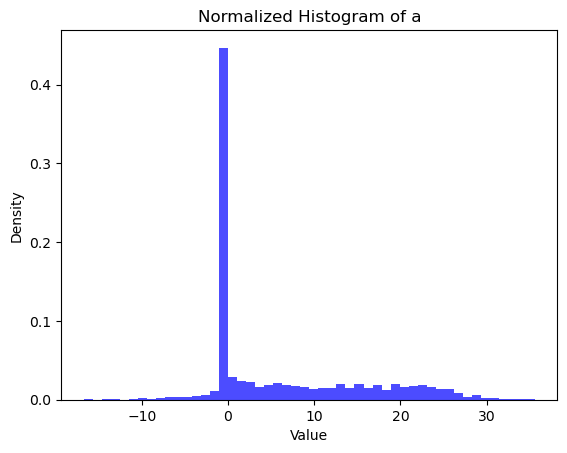

In [15]:
df = pd.DataFrame(jj)
fc = df.iloc[:,0].astype('float32')
print(fc.shape)
import matplotlib.pyplot as plt

plt.hist(fc, bins=50, color='blue', alpha=0.7, density=True)
plt.title('Normalized Histogram of a')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [22]:
# Custom bins

a = fc[~fc.isnull()]

# Calculate min, max, and percentiles by 10 for 'a'
min_val = a.min()
max_val = a.max()
percentiles = np.percentile(a, np.arange(0, 101, 10))

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Percentiles: {percentiles}")


Min: -15.8515625
Max: 35.59375
Percentiles: [-15.8515625    0.           0.           0.           0.
   0.30004883   5.          10.6015625   16.703125    22.203125
  35.59375   ]
